In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA


def generate_data(n_inliers=100, n_outliers=20, d=3):
   
    
    
    D = d + 1

    
    A = np.random.randn(D, D)
    A1 = np.random.randn(D, D)
    Q, _ = np.linalg.qr(A)
    Q1, _ = np.linalg.qr(A1)

    
    P_inlier = Q[:, :d]  # shape: (D, d)
    P_orth = Q[:,2:]
    P_outlier = Q1[:, d]  # shape: (D,)

   
    inliers = np.random.randn(n_inliers, d)
    inliers_embedded = inliers @ P_inlier.T

    
    outliers = np.random.randn(n_outliers, 1)
    noise = np.random.randn(n_outliers,1)
    outliers = outliers + 0*noise
    outliers_embedded = outliers * P_outlier.reshape(1, -1)

    
    data = np.concatenate([inliers_embedded, outliers_embedded], axis=0)

    
    norms = np.linalg.norm(data, axis=1, keepdims=True)
    data_normalized = data / norms

    return data_normalized, P_inlier,P_orth

In [2]:
def FMS_small(X, dd,L0):
    
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=200

  
    L = L0
    # Dictionary to store intermediate L values at every iteration
    L_intermediate = {}


    for iter_count in range(1, max_iter + 1):
        L_old = L.copy()

        residual = (np.eye(D) - L @ L.T) @ X

        w = np.maximum(1e-10, np.sqrt(np.sum(residual**2, axis=0)))

        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        ang = np.linalg.norm(subspace_angles(L, L_old))

        # Store L at the current iteration
        L_intermediate[iter_count] = L.copy()


    return L, L_intermediate

def FMS_large(X, dd,L0):
    
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=200

    
    L = L0

    L_intermediate = {}

    
    ang = 1

    for iter_count in range(1, max_iter + 1):
        L_old = L.copy()

        # Residual projection onto the orthogonal complement of L
        residual = (np.eye(D) - L @ L.T) @ X

        # Compute weights with a small regularization
        w = np.maximum(1e-3, np.sqrt(np.sum(residual**2, axis=0)))


        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute convergence metric using your subspace_angles function
        ang = np.linalg.norm(subspace_angles(L, L_old))

        L_intermediate[iter_count] = L.copy()

        iter_count += 1

    return L, L_intermediate

def FMS_dc(X, dd,gamma,L0):
    
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=200
    
    L = L0


    residual = (np.eye(D) - L @ L.T) @ X
    distances = np.sqrt(np.sum(residual**2, axis=0))
    epsilon0 = np.quantile(distances, gamma)

    L_intermediate = {}
    

 
    ang = 1

    for iter_count in range(1, max_iter + 1):
        L_old = L

        # Residual projection onto the orthogonal complement of L
        residual = (np.eye(D) - L_old @ L_old.T) @ X
        distances = np.sqrt(np.sum(residual**2, axis=0))
        
        # Update smoothing parameter: dynamic update based on the gamma-th quantile.
        q_gamma_val = np.quantile(distances, gamma)
        epsilon = min(epsilon0, q_gamma_val)
        
        w = np.maximum(epsilon, distances)
       
        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute convergence metric using your subspace_angles function
        ang = np.linalg.norm(subspace_angles(L, L_old))

        L_intermediate[iter_count] = L.copy()

        iter_count += 1

    return L, L_intermediate,epsilon
# return the epsilon of FMS_ds,

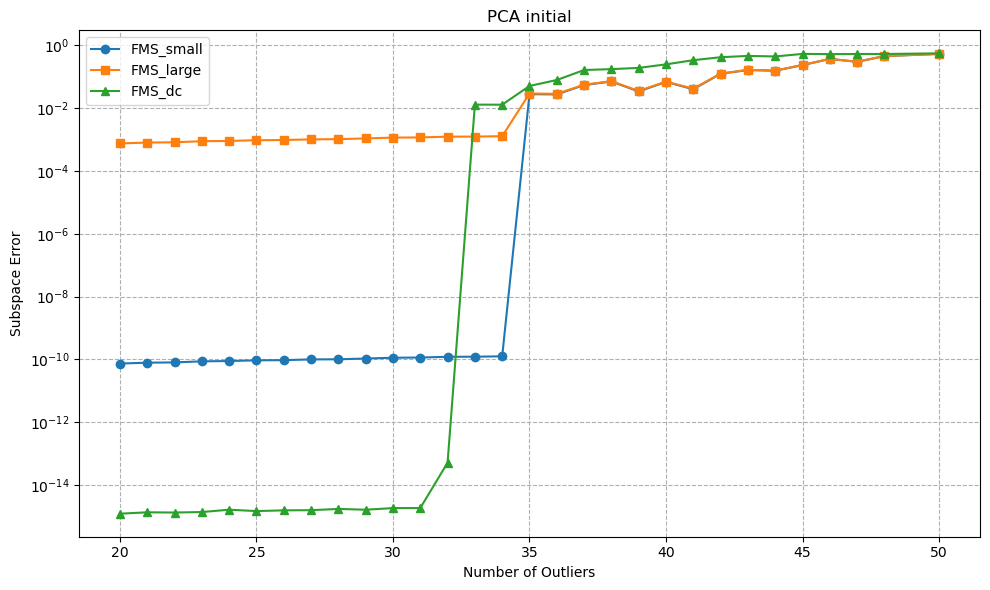

In [ ]:
#PCA Initial
repeats = 100
num1 = 100  # number of inliers
d = 3
np.random.seed(42)


outlier_counts = np.linspace(20, 50, 30,dtype=int)


avg_errors_small = {}
avg_errors_large = {}
avg_errors_dc = {}


for num2 in outlier_counts:
    errors_small = []
    errors_large = []
    errors_dc = []
    #gamma = num1/(num1+num2) # inlier percentage
    gamma = 0.5
    epsilons=[]
    for trial in range(repeats):
        
        data, P_true, P_orth = generate_data(n_inliers=num1, n_outliers=num2, d=d)
        U, _, _ = np.linalg.svd(data.T, full_matrices=False)
        L0 = U[:, :d]



        # FMS_small 
        P_small, L_small = FMS_small2(data.T, d,L0)
        # FMS_large 
        P_large, L_large = FMS_large2(data.T, d,L0)
        # FMS_dc 
        P_dc, L_dc,epsilon = FMS_dc2(data.T, d, gamma,L0)
        
        
        error_small = np.linalg.norm(P_small @ P_small.T - P_true @ P_true.T)
        
        error_large = np.linalg.norm(P_large @ P_large.T - P_true @ P_true.T)
        error_dc    = np.linalg.norm(P_dc @ P_dc.T - P_true @ P_true.T)
        
        
        errors_small.append(error_small)
        errors_large.append(error_large)
        errors_dc.append(error_dc)
        epsilons.append(epsilon)
    
    
    avg_errors_small[num2] = np.mean(errors_small)
    avg_errors_large[num2] = np.mean(errors_large)
    avg_errors_dc[num2]    = np.mean(errors_dc)
    
    #print(f"\nFor {num2} outliers:")
    #print("Average FMS_small error:", avg_errors_small[num2])
    #print("Average FMS_large error:", avg_errors_large[num2])
    #print("Average FMS_dc error:",    avg_errors_dc[num2])


plt.figure(figsize=(10, 6))

num_outliers_sorted = sorted(avg_errors_small.keys())
avg_small = [avg_errors_small[x] for x in num_outliers_sorted]
avg_large = [avg_errors_large[x] for x in num_outliers_sorted]
avg_dc    = [avg_errors_dc[x] for x in num_outliers_sorted]

plt.plot(num_outliers_sorted, avg_small, marker='o', label='FMS_small')
plt.plot(num_outliers_sorted, avg_large, marker='s', label='FMS_large')
plt.plot(num_outliers_sorted, avg_dc, marker='^', label='FMS_dc')

plt.xlabel("Number of Outliers")
plt.ylabel("Subspace Error")
plt.title("PCA initial")
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig('exp2_PCA.png', dpi=300, bbox_inches='tight')
plt.show()



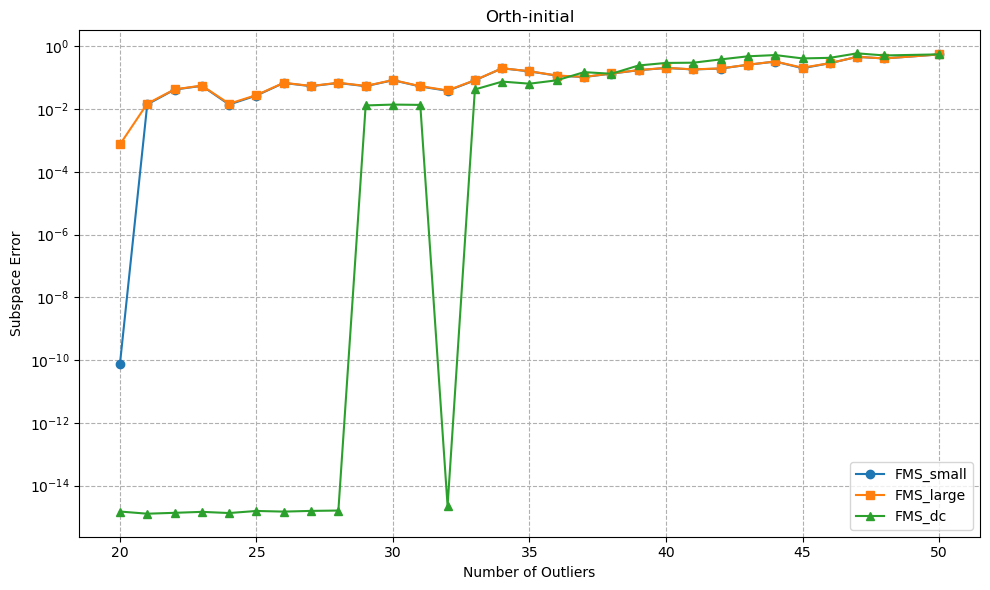

In [33]:
#orthogonal Initial
repeats = 100
num1 = 100  # number of inliers
d = 3
#gamma = 0.1


outlier_counts = np.linspace(20, 50, 30,dtype=int)


avg_errors_small = {}
avg_errors_large = {}
avg_errors_dc = {}


for num2 in outlier_counts:
    errors_small = []
    errors_large = []
    errors_dc = []
    #gamma = num1/(num1+num2)
    gamma = 0.5
    for trial in range(repeats):
        
        data, P_true, P_orth = generate_data(n_inliers=num1, n_outliers=num2, d=d)
        L0 = P_orth



        # FMS_small 
        P_small, L_small = FMS_small(data.T, d,L0)
        # FMS_large 
        P_large, L_large = FMS_large(data.T, d,L0)
        # FMS_dc 
        P_dc, L_dc = FMS_dc(data.T, d, gamma,L0)
        
        
        error_small = np.linalg.norm(P_small @ P_small.T - P_true @ P_true.T)
        error_large = np.linalg.norm(P_large @ P_large.T - P_true @ P_true.T)
        error_dc    = np.linalg.norm(P_dc @ P_dc.T - P_true @ P_true.T)
        
        
        errors_small.append(error_small)
        errors_large.append(error_large)
        errors_dc.append(error_dc)
    
    
    avg_errors_small[num2] = np.mean(errors_small)
    avg_errors_large[num2] = np.mean(errors_large)
    avg_errors_dc[num2]    = np.mean(errors_dc)
    
    #print(f"\nFor {num2} outliers:")
    #print("Average FMS_small error:", avg_errors_small[num2])
    #print("Average FMS_large error:", avg_errors_large[num2])
    #print("Average FMS_dc error:",    avg_errors_dc[num2])


plt.figure(figsize=(10, 6))

num_outliers_sorted = sorted(avg_errors_small.keys())
avg_small = [avg_errors_small[x] for x in num_outliers_sorted]
avg_large = [avg_errors_large[x] for x in num_outliers_sorted]
avg_dc    = [avg_errors_dc[x] for x in num_outliers_sorted]

plt.plot(num_outliers_sorted, avg_small, marker='o', label='FMS_small')
plt.plot(num_outliers_sorted, avg_large, marker='s', label='FMS_large')
plt.plot(num_outliers_sorted, avg_dc, marker='^', label='FMS_dc')

plt.xlabel("Number of Outliers")
plt.ylabel("Subspace Error")
plt.title("Orth-initial")
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig('exp2_ORTH.png', dpi=300, bbox_inches='tight')
plt.show()

# num_outliers = 20~30

In [3]:
def generate_data2(n_inliers=100, n_outliers=20, d=3):
   
    D = 2*d                             


    Q, _      = np.linalg.qr(np.random.randn(D, D))
    P_inlier  = Q[:, :d]                   # (D, d)
    P_orth    = Q[:, d:]                   # (D, D-d)

    inliers = np.random.randn(n_inliers, d) @ P_inlier.T      

    cov      = np.random.randn(D, D)                           
    outliers = np.random.randn(n_outliers, D) @ cov.T         

    data = np.vstack([inliers, outliers])                     


    norms = np.linalg.norm(data, axis=1, keepdims=True)
    data  = data / norms

    return data, P_inlier, P_orth

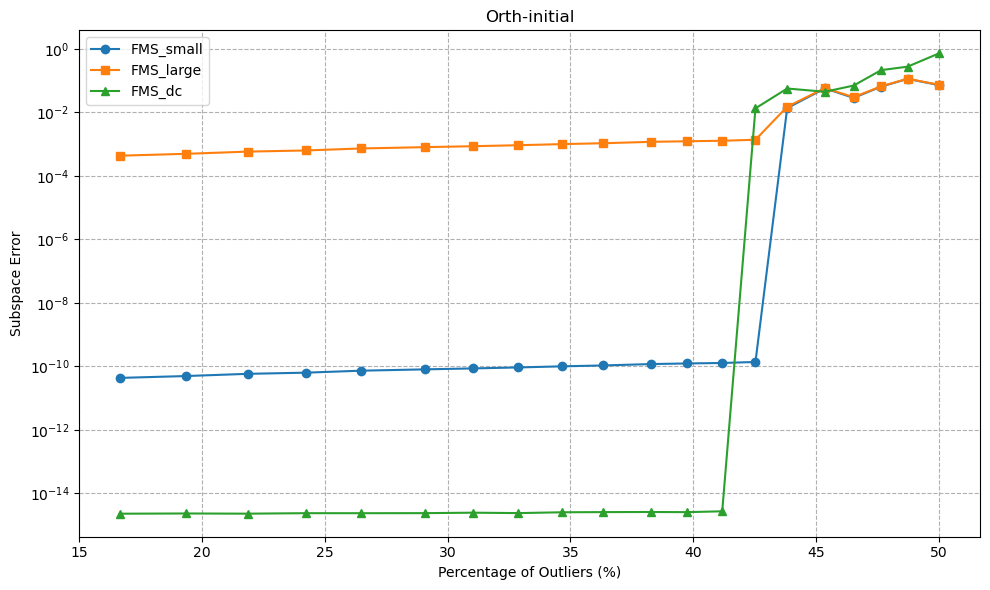

In [4]:

repeats = 100
num_inliers = 100
d = 6

outlier_counts = np.linspace(20, 100, 20, dtype=int)   


avg_errors_small = {}
avg_errors_large = {}
avg_errors_dc    = {}
epsilons={}

for num_out in outlier_counts:
    errors_small, errors_large, errors_dc = [], [], []
    gamma = 0.5
    eps = []

    for _ in range(repeats):
        data, P_true, P_orth = generate_data2(n_inliers=num_inliers,
                                              n_outliers=num_out, d=d)
        L0 = P_orth

        
        P_small, _ = FMS_small(data.T, d, L0)
        P_large, _ = FMS_large(data.T, d, L0)
        P_dc,_, epsilon = FMS_dc   (data.T, d, gamma, L0)

        
        errors_small.append(np.linalg.norm(P_small @ P_small.T - P_true @ P_true.T))
        errors_large.append(np.linalg.norm(P_large @ P_large.T - P_true @ P_true.T))
        errors_dc   .append(np.linalg.norm(P_dc    @ P_dc.T    - P_true @ P_true.T))
        eps.append(epsilon)
    
    pct = 100 * num_out / (num_inliers + num_out)      # percentage of outliers
    avg_errors_small[pct] = np.mean(errors_small)
    avg_errors_large[pct] = np.mean(errors_large)
    avg_errors_dc   [pct] = np.mean(errors_dc)
    epsilons[pct] = eps




plt.figure(figsize=(10, 6))


pct_sorted = sorted(avg_errors_small.keys())
avg_small  = [avg_errors_small[p] for p in pct_sorted]
avg_large  = [avg_errors_large[p] for p in pct_sorted]
avg_dc     = [avg_errors_dc   [p] for p in pct_sorted]

plt.plot(pct_sorted, avg_small,  marker='o', label='FMS_small')
plt.plot(pct_sorted, avg_large,  marker='s', label='FMS_large')
plt.plot(pct_sorted, avg_dc,     marker='^', label='FMS_dc')

plt.xlabel("Percentage of Outliers (%)")       
plt.ylabel("Subspace Error")
plt.title("Orth-initial")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("exp2_ORTH_ambient(D=2d).png", dpi=300, bbox_inches="tight")
plt.show()
# 